# Produce Sky flats


- Creation : Tuesday 2016 June 7th
- Author Sylvie Dagoret-Campagne (SDC adapted for LSST from Matt Craig's example notebook)
- affiliation : LAL/IN2P3/CNRS




In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [38]:
from scipy import stats  
import os
from datetime import datetime, timedelta

In [39]:
import libMonocamBaseImages

In [40]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-06-07 15:42:06.802881
fits date format for the analysis :  2016-06-07T15:42:06


In [41]:
NB_OF_CHAN_AMPL=16    # 16 images in each of the fits file

## 1) Get the master bias 

In [42]:
path='.'
basefilename='masterbias_ostrim_1.fits' # check master bias
#basefilename='masterdarkscaled_ostrim_1.fits' # check master dark
filename=os.path.join(path,basefilename)
vmin=-2
vmax=2

In [43]:
allbias = []
for chan in range(1,NB_OF_CHAN_AMPL+1,1):
    ccd_chan = ccdproc.CCDData.read(filename, hdu=chan,unit="adu") 
    allbias.append(ccd_chan)

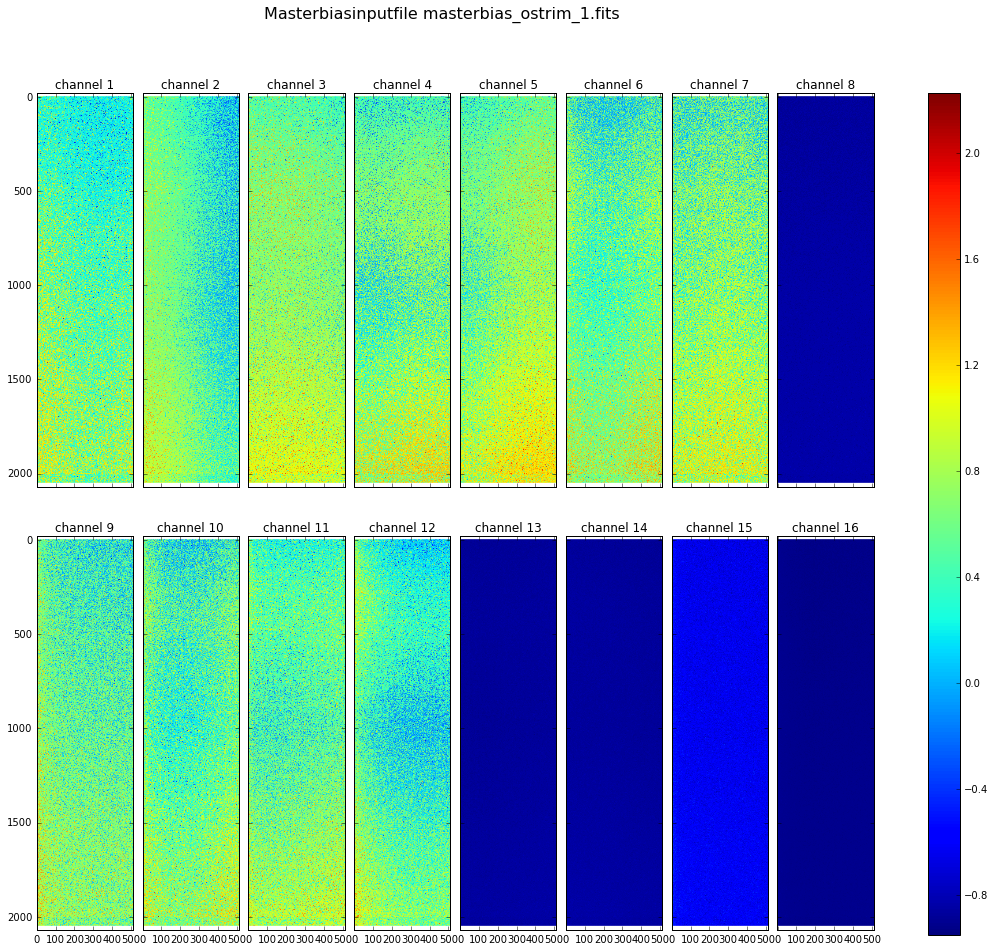

In [44]:
#libMonocamBaseImages.ShowImagesSet(allbias)
libMonocamBaseImages.ShowImagesSet(allbias,'Masterbias',basefilename,'masterbiases_img.pdf')

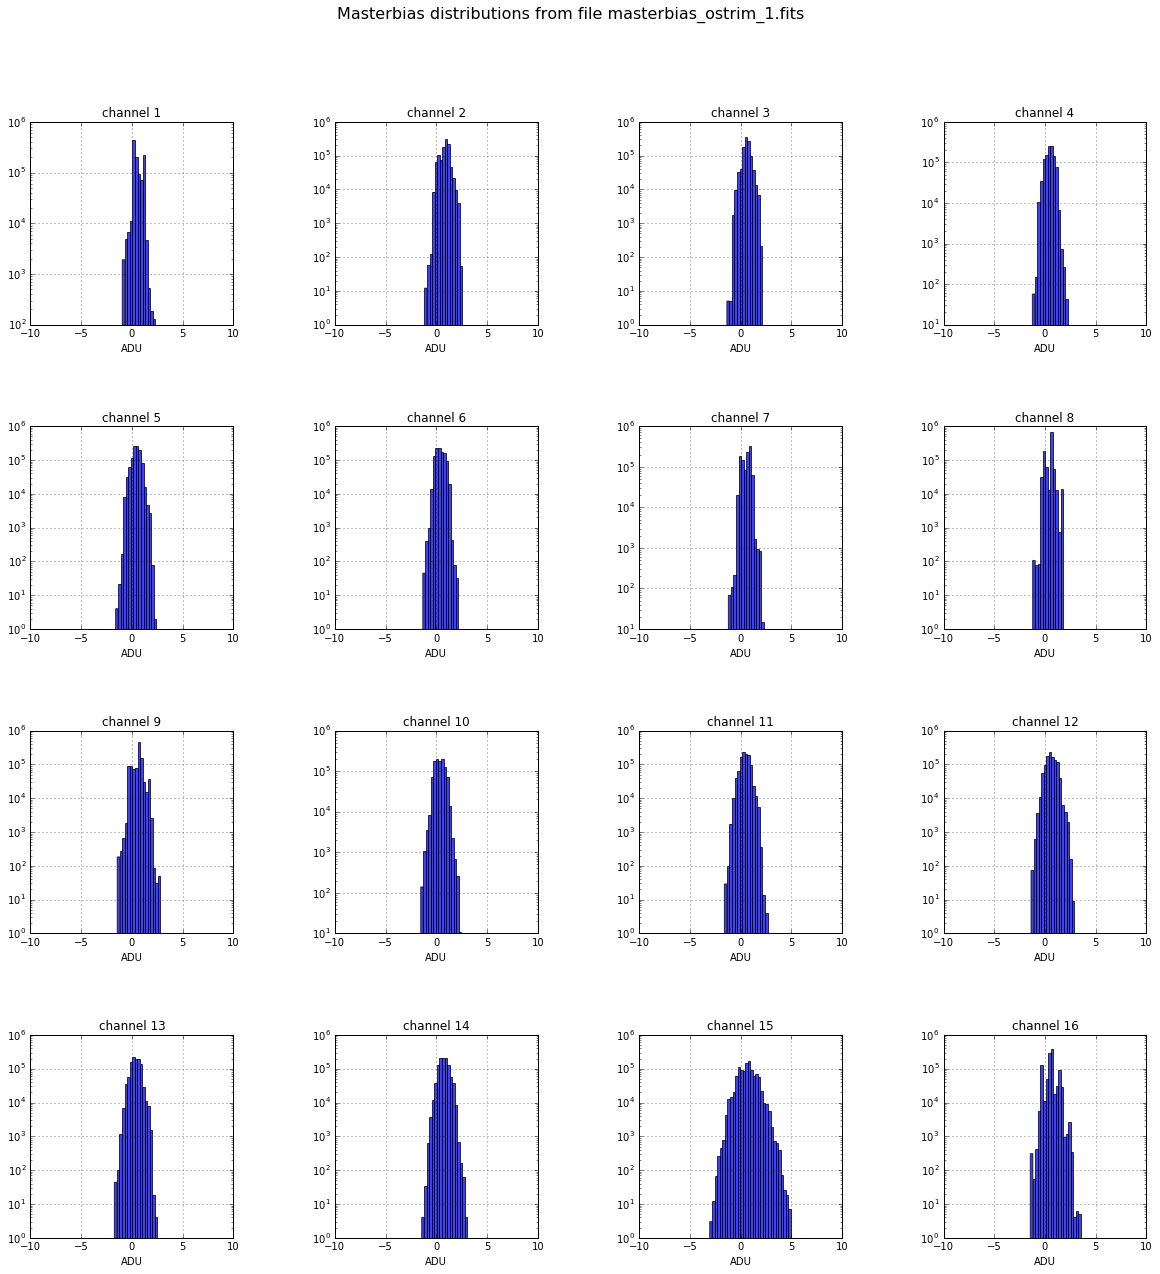

In [45]:
libMonocamBaseImages.ShowHistoSet(allbias,'Masterbias distributions',basefilename,'masterbiases_hist.pdf')

## 2) Get the scaled darks

In [46]:
path='.'
basefilename='masterdarkscaled_ostrim_1.fits' # check master dark
filename=os.path.join(path,basefilename)
vmin=-2
vmax=2

In [47]:
alldarks = []
for chan in range(1,NB_OF_CHAN_AMPL+1,1):
    ccd_chan = ccdproc.CCDData.read(filename, hdu=chan,unit="adu") 
    alldarks.append(ccd_chan)

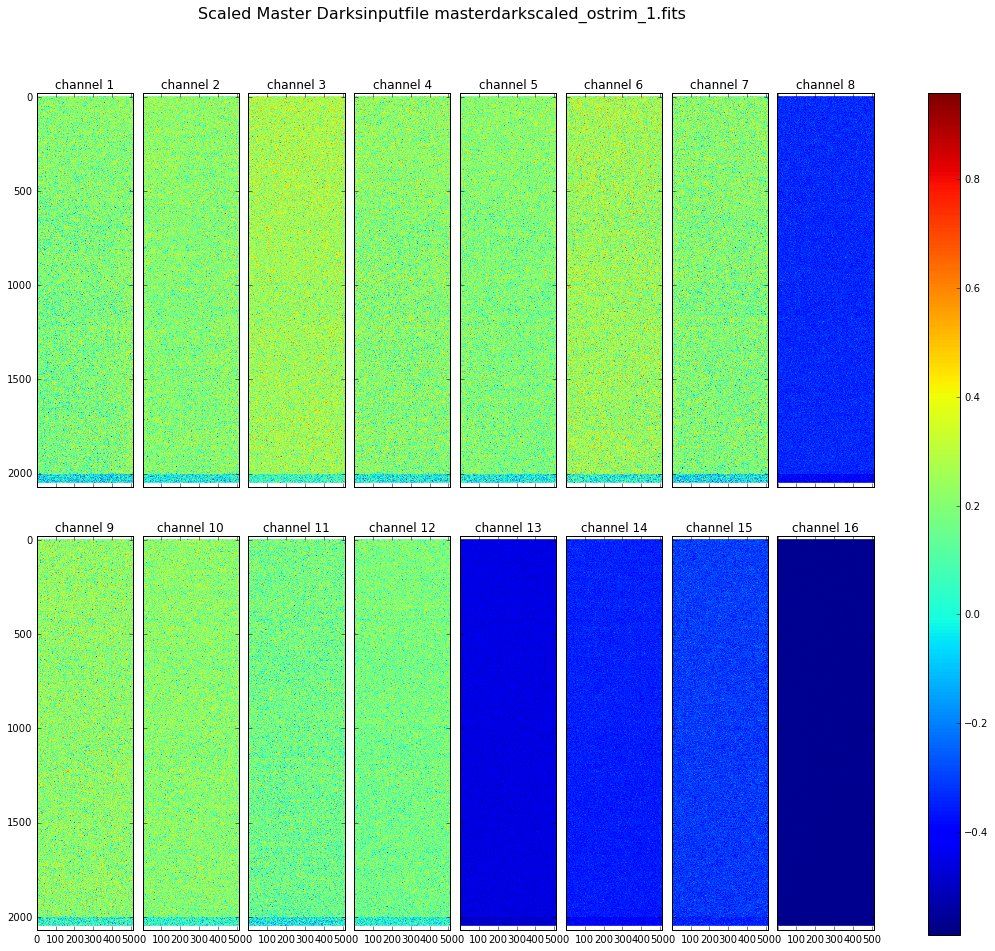

In [48]:
libMonocamBaseImages.ShowImagesSet(alldarks,'Scaled Master Darks',basefilename,'masterdarks_img.pdf')

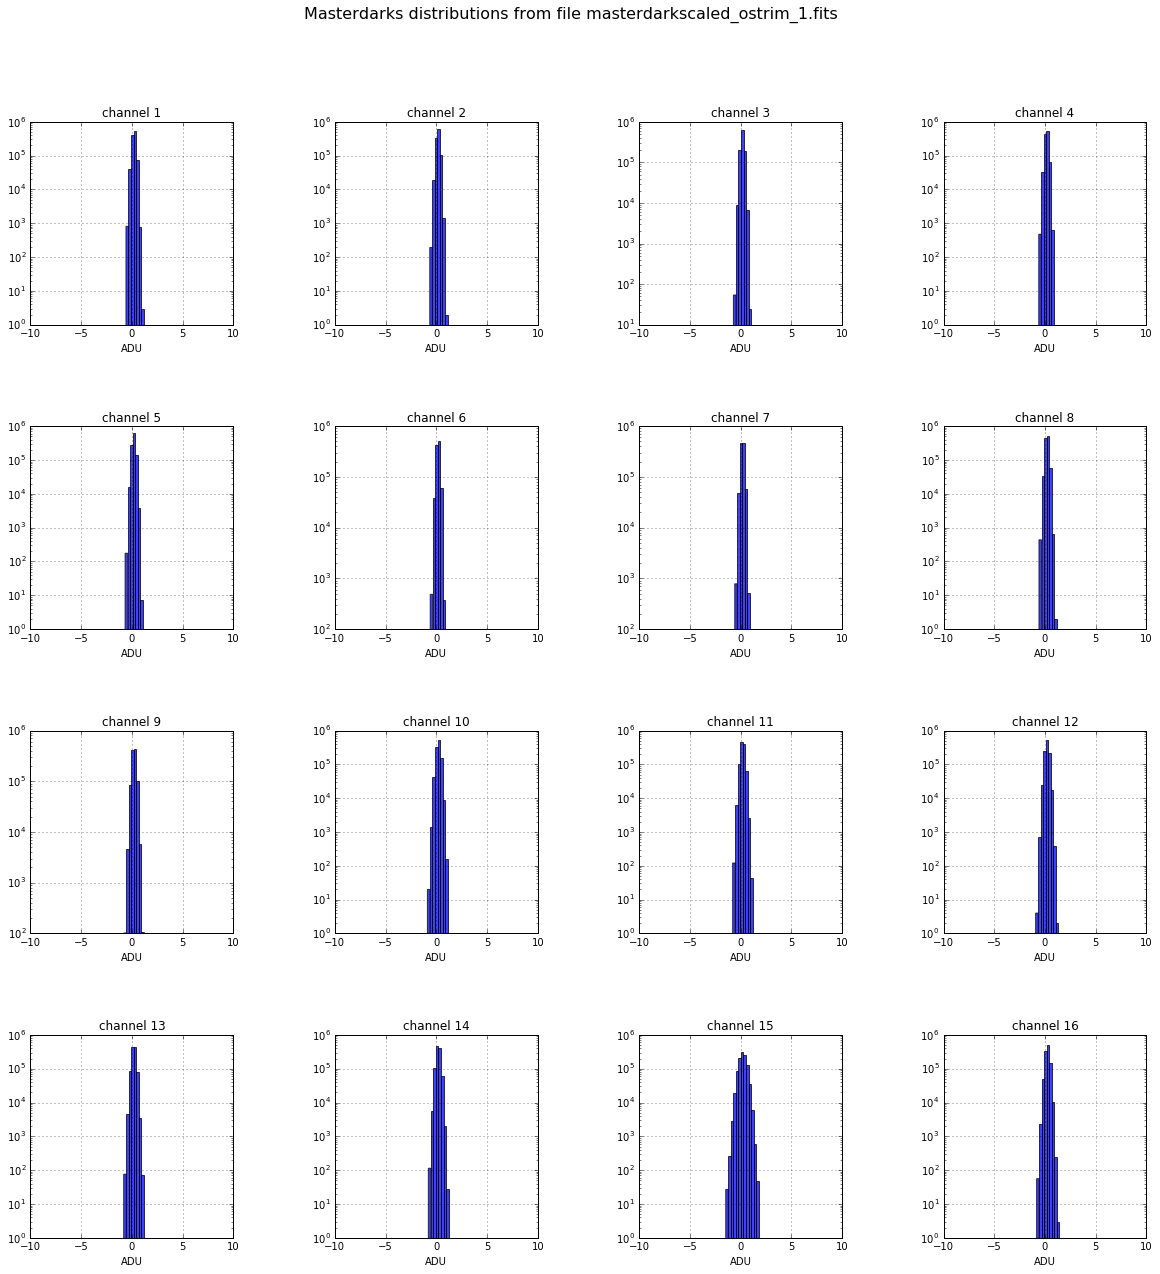

In [49]:
libMonocamBaseImages.ShowHistoSet(alldarks,'Masterdarks distributions',basefilename,'masterdarks_hist.pdf')

## 3)  Raw sky flats

In [50]:
path='/Users/dagoret-campagnesylvie/iraf/MonoCamMay2016/20160509'
root_skyflatfilename='skyflats_'
skyflat_startnum=1
skyflat_stopnum=40 

In [51]:
rawskyflat_list=libMonocamBaseImages.BuildFilelist(path,root_skyflatfilename,start=skyflat_startnum,stop=skyflat_stopnum)

In [52]:
NB_OF_SKYFLATS=len(rawskyflat_list)

### a) Read the skyflat images

In [53]:
allchannelallskyflat = []  # list of 16 lists of sky-flats 
exposures_list = []        # sequential list of the exposures of the sky flats 
header_list = []           # list of headers

# get the primary block headers:
for image_file in rawskyflat_list: 
    hdu_list = fits.open(image_file)
    header=hdu_list[0].header
    number_of_channels=header['CHAN']
    exposure=header['EXPOSURE']
    exposures_list.append(exposure)
    header_list.append(header)

# get the CCD images:
for chan in range(1,NB_OF_CHAN_AMPL+1,1): # loop on channel
    fileindex=0
    allskyflat = []  # container of flats for a given channel
    for image_file in rawskyflat_list:       
        ccd_chan = ccdproc.CCDData.read(image_file, hdu=chan,unit="adu")
        allskyflat.append(ccd_chan)  # image extension
        fileindex=fileindex+1
    allchannelallskyflat.append(allskyflat)
        
        

### b) Substract overscan and trim

In [54]:
def oscan_and_trim(image_list):
    """
    Remove overscan and trim a list of images. The original list is replaced by a list of images
    with the changes applied.
    """
    for idx, img in enumerate(image_list):
        oscan = ccdproc.subtract_overscan(img,overscan=img[:,521:544], add_keyword={'oscan_sub': True, 'calstat': 'O'}, model=models.Polynomial1D(1))
        image_list[idx] = ccdproc.trim_image(oscan[:,10:521], add_keyword={'trimmed': True, 'calstat': 'OT'})

In [55]:
# oscan and trim the image for each channel 
for chan in range(NB_OF_CHAN_AMPL):
    # oscan all the flats for that channel
    libMonocamBaseImages.oscan_and_trim(allchannelallskyflat[chan])

### c) Substract the bias

In [56]:
allchannelsallskyflat_corrbias = []  # list of 16 lists of sky-flats 
for chan in range(NB_OF_CHAN_AMPL):
    allskyflat_corrbias = []  # list of skyflats corrected for bias for a given channel
    for idx, img in enumerate(allchannelallskyflat[chan]):
        bias_substracted=ccdproc.subtract_bias(img,allbias[chan])
        allskyflat_corrbias.append(bias_substracted)
    allchannelsallskyflat_corrbias.append(allskyflat_corrbias)
    
    
    
    

In [57]:
allchannelsallskyflat_corrdark = []  # list of 16 lists of sky-flats 
for chan in range(NB_OF_CHAN_AMPL):
    allskyflat_corrdark = []
    for idx, img in enumerate(allchannelsallskyflat_corrbias[chan]):
        dark_substracted=ccdproc.subtract_dark(img,alldarks[chan],data_exposure=exposures_list[idx]*u.second,dark_exposure=1*u.second,scale=True)
        allskyflat_corrdark.append(dark_substracted)
    allchannelsallskyflat_corrdark.append(allskyflat_corrdark)


### c) Combination, sigma clip and master flat

In [58]:
flat_combiner_list = []
for chan in range(NB_OF_CHAN_AMPL):
    flat_combiner=ccdproc.Combiner(allchannelsallskyflat_corrdark[chan])
    flat_combiner.sigma_clipping(func=libMonocamBaseImages.med_over_images)
    flat_combiner_list.append(flat_combiner)

### d) Master flat


In [59]:
scaling_func= lambda arr: 1/np.ma.average(arr)

In [60]:
for chan in range(NB_OF_CHAN_AMPL):
    flat_combiner_list[chan].scaling=scaling_func

In [61]:
masterflat_list=[]
for chan in range(NB_OF_CHAN_AMPL):
    masterflat=flat_combiner_list[chan].median_combine(median_func=libMonocamBaseImages.bn_median)
    masterflat.header=allchannelallskyflat[chan][0].meta
    masterflat_list.append(masterflat)

In [67]:
masterflat_list[0]

CCDData([[ 2.18237216,  2.16886764,  2.14972643, ...,  0.68498444,
           0.64985425,  0.63301439],
         [ 0.8210111 ,  0.82880535,  0.81470449, ...,  0.65037268,
           0.61910228,  0.60559264],
         [ 0.86252219,  0.88103643,  0.86367234, ...,  0.70090849,
           0.66352498,  0.64009248],
         ..., 
         [-0.01446295, -0.01448593, -0.01439268, ..., -0.01450802,
          -0.01481111, -0.01440755],
         [-0.01465488, -0.01468575, -0.01465715, ..., -0.01447901,
          -0.01459974, -0.01442626],
         [-0.01446017, -0.01463121, -0.01455577, ..., -0.01456829,
          -0.01436182, -0.01460468]])

In [64]:
imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

In [78]:
index=2
image=masterflat_list[index]

In [79]:
f_min,f_max_,f_mean,f_std=imstats(np.asarray(image))

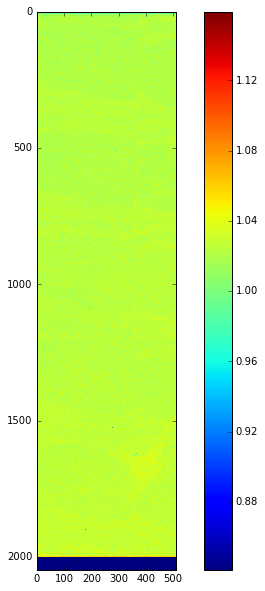

In [80]:
plt.figure(figsize=(10,10))
plt.imshow(image,vmin=f_mean-f_std,vmax=f_mean+f_std)
plt.colorbar()

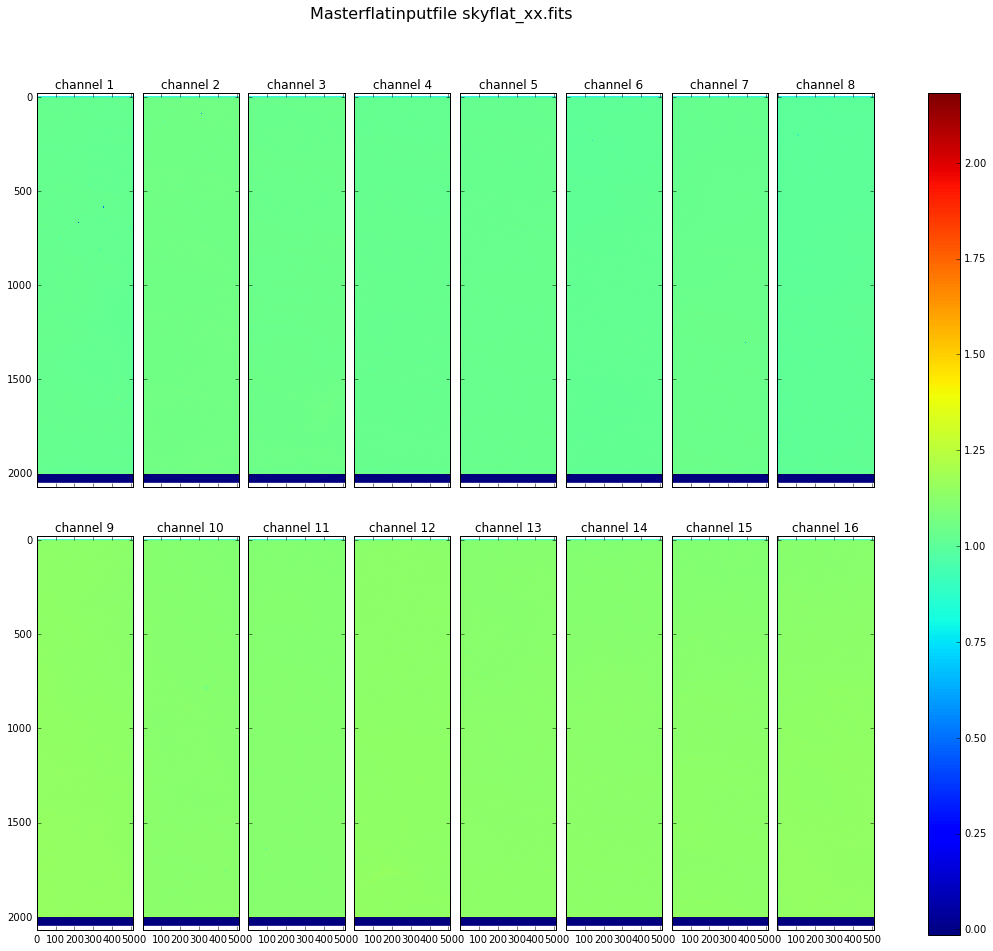

In [81]:
libMonocamBaseImages.ShowImagesSet(masterflat_list,'Masterflat','skyflat_xx.fits','masterflat_img.pdf')